In [3]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import re
import random
from tqdm import tqdm

import torch
import torch.nn as nn 
from torch import optim
import torch.nn.functional as F

import numpy as np
from torch.utils.data import DataLoader, TensorDataset, RandomSampler

device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'
device


device(type='cuda')

#  Loading Data Files

In [4]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.index2word = {}
        self.word2count = {0: "SOS", 1: "EOS"}
        self.n_words = 2 # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)
    
    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.index2word[self.n_words] = word
            self.word2count[word] = 1
            self.n_words+=1
        else:
            self.word2count[word]+=1

In [5]:
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z!?]+", r" ", s)
    return s.strip()

In [6]:
def readLangs(lang1, lang2, reverse=False):
    # Read the files and split into line
    lines = open(f'data/{lang1}-{lang2}.txt', encoding='utf-8').\
    read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)
    
    return input_lang, output_lang, pairs

In [7]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)

def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

### The full process for preparing the data is:

1. Read text file and split into lines, split lines into pairs
2. Normalize text, filter by length and content
3. Make word lists from sentences in pairs

In [8]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)

    print(f'Read {len(pairs)} setennce pairs')

    pairs = filterPairs(pairs)
    print(f"Trimmed to {len(pairs)} sentence pairs")

    print('Counting words...')
    for pair in tqdm(pairs, total=len(pairs)):
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])

    print("Counted words: ")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)

    return input_lang, output_lang, pairs

input_lang, output_lang, pairs = prepareData('eng', 'fra', reverse=True)
print(random.choice(pairs))

Read 135842 setennce pairs
Trimmed to 11445 sentence pairs
Counting words...


100%|██████████| 11445/11445 [00:00<00:00, 400930.50it/s]

Counted words: 
fra 4601
eng 2991
['je suis desolee', 'i m sorry']


# Seq2Seq model

## Encoder

In [9]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout=0.1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embed = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input):
        embeddings = self.dropout(self.embed(input))
        output, hidden = self.gru(embeddings)

        return output, hidden

## Decoder

In [10]:
class DecoderRNN(nn.Module):
    def __init__(self, output_size, hidden_size):
        super(DecoderRNN, self).__init__()
        
        self.embed = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []
        
        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden = self.forward_step(decoder_input, decoder_hidden)
            decoder_outputs.append(decoder_output)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1)
            else:
                # Without Teacher forcing: Using its own output as inputs
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()
        
        decoder_outputs = torch.concat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=1)

        return decoder_outputs, decoder_hidden, None # We return None for consistency in the training loop

    def forward_step(self, input, hidden):
        output = self.embed(input)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.out(output)
        return output, hidden

In [11]:
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()
        self.Wa = nn.Linear(hidden_size, hidden_size)
        self.Ua = nn.Linear(hidden_size, hidden_size)
        self.Va = nn.Linear(hidden_size, 1)

    def forward(self, query, keys):
        scores = self.Va(torch.tanh(self.Wa(query)+self.Ua(keys)))
        scores = scores.squeeze(2).unsqueeze(1)
        weights = F.softmax(scores, dim=-1)
        context = torch.bmm(weights, keys)

        return context, weights

In [12]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        self.embed = nn.Embedding(output_size, hidden_size)
        self.attention = BahdanauAttention(hidden_size)
        self.gru = nn.GRU(2*hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_p)
    
    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).\
            fill_(SOS_token)
        
        decoder_hidden = encoder_hidden
        decoder_outputs = []
        attentions = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None:
                decoder_input = target_tensor[:, i].unsqueeze(1)
            else:
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()
        
        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        attentions = torch.cat(attentions, dim=1)

        return decoder_outputs, decoder_hidden, attentions
    
    def forward_step(self, input, hidden, encoder_outputs):
        embedded = self.dropout(self.embed(input))

        query = hidden.permute(1, 0, 2)
        context, attn_weights = self.attention(query, encoder_outputs)
        input_gru = torch.cat((embedded, context), dim=2)

        output, hidden = self.gru(input_gru, hidden)
        output = self.out(output)

        return output, hidden, attn_weights

# Training
## Preparing Training Data

In [13]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(1, -1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

def get_dataloader(batch_size):
    input_lang, output_lang, pairs = prepareData('eng', 'fra', True)

    n = len(pairs)
    input_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)
    target_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)

    for idx, (inp, tgt) in enumerate(pairs):
        inp_ids = indexesFromSentence(input_lang, inp)
        tgt_ids = indexesFromSentence(output_lang, tgt)
        inp_ids.append(EOS_token)
        tgt_ids.append(EOS_token)
        input_ids[idx, :len(inp_ids)] = inp_ids
        target_ids[idx, :len(tgt_ids)] = tgt_ids

    train_data = TensorDataset(torch.LongTensor(input_ids).to(device),
                               torch.LongTensor(target_ids).to(device))

    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
    return input_lang, output_lang, train_dataloader

## Training the Model

In [14]:
def train_epoch(dataloader, encoder, decoder, encoder_optimizer,
          decoder_optimizer, criterion):

    total_loss = 0
    for data in dataloader:
        input_tensor, target_tensor = data

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

In [15]:
import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [16]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [17]:
from tqdm import tqdm

In [18]:
def train(train_dataloader, encoder, decoder, n_epochs, learning_rate=0.001,
               print_every=100, plot_every=100):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()

    for epoch in tqdm(range(1, n_epochs + 1), total=n_epochs):
        loss = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, epoch / n_epochs),
                                        epoch, epoch / n_epochs * 100, print_loss_avg))

        if epoch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [19]:
def evaluate(encoder, decoder, sentence, input_lang, output_lang):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, decoder_hidden, decoder_attn = decoder(encoder_outputs, encoder_hidden)

        _, topi = decoder_outputs.topk(1)
        decoded_ids = topi.squeeze()

        decoded_words = []
        for idx in decoded_ids:
            if idx.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            decoded_words.append(output_lang.index2word[idx.item()])
    return decoded_words, decoder_attn

In [20]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, _ = evaluate(encoder, decoder, pair[0], input_lang, output_lang)
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [21]:
hidden_size = 128
batch_size = 32

input_lang, output_lang, train_dataloader = get_dataloader(batch_size)

encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = AttnDecoderRNN(hidden_size, output_lang.n_words).to(device)

Read 135842 setennce pairs
Trimmed to 11445 sentence pairs
Counting words...


100%|██████████| 11445/11445 [00:00<00:00, 342854.96it/s]

Counted words: 
fra 4601
eng 2991


In [22]:
encoder

EncoderRNN(
  (embed): Embedding(4601, 128)
  (gru): GRU(128, 128, batch_first=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

  6%|▋         | 5/80 [00:20<05:05,  4.08s/it]

0m 21s (- 5m 23s) (5 6%) 1.5463


 12%|█▎        | 10/80 [00:40<04:40,  4.01s/it]

0m 41s (- 4m 51s) (10 12%) 0.6941


 19%|█▉        | 15/80 [01:01<04:21,  4.02s/it]

1m 1s (- 4m 28s) (15 18%) 0.3631


 25%|██▌       | 20/80 [01:20<03:58,  3.97s/it]

1m 21s (- 4m 5s) (20 25%) 0.2023


 31%|███▏      | 25/80 [01:40<03:39,  3.99s/it]

1m 41s (- 3m 43s) (25 31%) 0.1256


 38%|███▊      | 30/80 [02:00<03:17,  3.95s/it]

2m 1s (- 3m 22s) (30 37%) 0.0862


 44%|████▍     | 35/80 [02:20<02:56,  3.92s/it]

2m 21s (- 3m 1s) (35 43%) 0.0656


 50%|█████     | 40/80 [02:39<02:36,  3.92s/it]

2m 40s (- 2m 40s) (40 50%) 0.0532


 56%|█████▋    | 45/80 [03:00<02:23,  4.09s/it]

3m 1s (- 2m 20s) (45 56%) 0.0454


 62%|██████▎   | 50/80 [03:22<02:11,  4.39s/it]

3m 23s (- 2m 2s) (50 62%) 0.0408


 69%|██████▉   | 55/80 [03:43<01:44,  4.16s/it]

3m 43s (- 1m 41s) (55 68%) 0.0377


 75%|███████▌  | 60/80 [04:20<02:59,  8.98s/it]

4m 21s (- 1m 27s) (60 75%) 0.0349


 81%|████████▏ | 65/80 [05:01<01:33,  6.24s/it]

5m 2s (- 1m 9s) (65 81%) 0.0330


 88%|████████▊ | 70/80 [05:20<00:43,  4.31s/it]

5m 21s (- 0m 45s) (70 87%) 0.0313


 94%|█████████▍| 75/80 [05:41<00:21,  4.23s/it]

5m 42s (- 0m 22s) (75 93%) 0.0298


100%|██████████| 80/80 [06:03<00:00,  4.55s/it]

6m 4s (- 0m 0s) (80 100%) 0.0292


<Figure size 640x480 with 0 Axes>

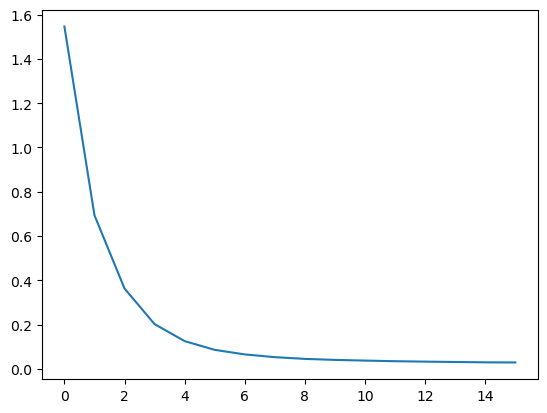

In [23]:
train(train_dataloader, encoder, decoder, 80, print_every=5, plot_every=5)

In [24]:
encoder.eval()
decoder.eval()
evaluateRandomly(encoder, decoder)

> ils sont tous semblables
= they re all alike
< they are all alike <EOS>

> elle est aussi jeune que moi
= she is as young as i am
< she is as young as i am <EOS>

> je suis heureux d etre de retour
= i m happy to be back
< i m happy to be back <EOS>

> tu n es pas drole
= you re no fun
< you re no fun <EOS>

> vous etes le chef
= you re the leader
< you re the leader <EOS>

> j ai vraiment sommeil
= i m really sleepy
< i m really sleepy sleepy sleepy <EOS>

> c est un travailleur du batiment
= he s a construction worker
< he s a construction worker <EOS>

> je ne vais pas m en meler
= i m not going to get involved
< i m not going to get involved <EOS>

> je n ai pas du tout peur des chiens
= i am not in the least afraid of dogs
< i am not in the least afraid of dogs <EOS>

> nous ne sommes pas idiots
= we re not stupid
< we re not stupid <EOS>



In [25]:
text = "vous etes tres belle"
output_text, _ = evaluate(encoder, decoder, text, input_lang, output_lang)
print(text)
' '.join(output_text)

vous etes tres belle


'you are very beautiful <EOS>'

# Visualizing attention

input = il n est pas aussi grand que son pere
output = he is not as tall as his father <EOS>


C:\Users\Ronit\AppData\Local\Temp\ipykernel_25748\1690937169.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + input_sentence.split(' ') +
C:\Users\Ronit\AppData\Local\Temp\ipykernel_25748\1690937169.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words)


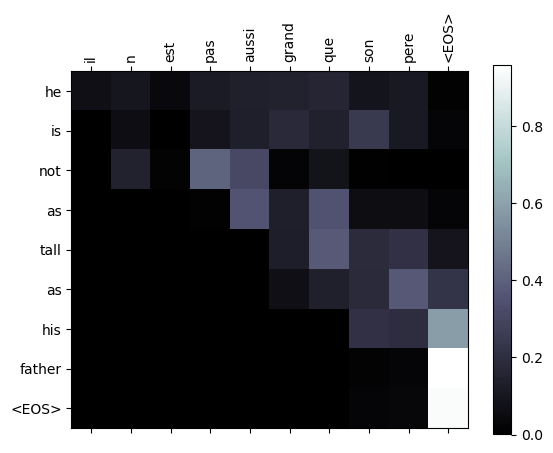

input = je suis trop fatigue pour conduire
output = i m too tired to drive <EOS>


C:\Users\Ronit\AppData\Local\Temp\ipykernel_25748\1690937169.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + input_sentence.split(' ') +
C:\Users\Ronit\AppData\Local\Temp\ipykernel_25748\1690937169.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words)


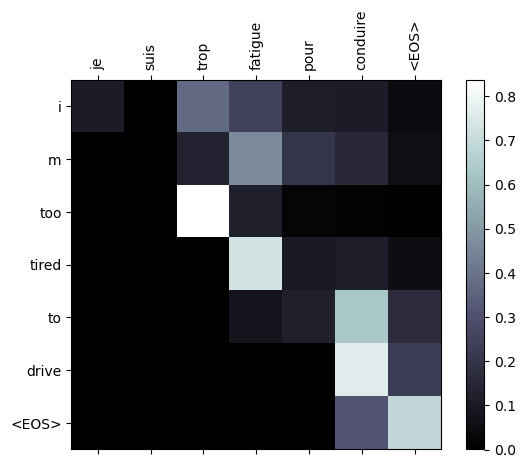

input = je suis desole si c est une question idiote
output = i m sorry if this is a stupid question <EOS>


C:\Users\Ronit\AppData\Local\Temp\ipykernel_25748\1690937169.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + input_sentence.split(' ') +
C:\Users\Ronit\AppData\Local\Temp\ipykernel_25748\1690937169.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words)


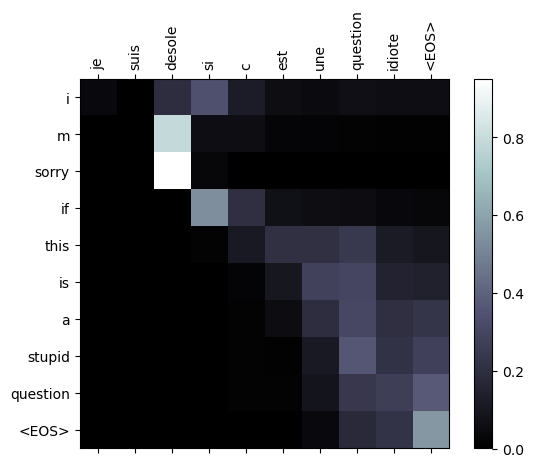

input = je suis reellement fiere de vous
output = i m really proud of you happy <EOS>


C:\Users\Ronit\AppData\Local\Temp\ipykernel_25748\1690937169.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + input_sentence.split(' ') +
C:\Users\Ronit\AppData\Local\Temp\ipykernel_25748\1690937169.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words)


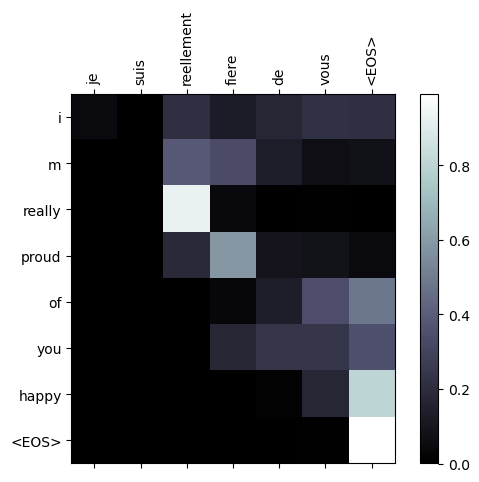

In [26]:
def showAttention(input_sentence, output_words, attentions):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.cpu().numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(encoder, decoder, input_sentence, input_lang, output_lang)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions[0, :len(output_words), :])


evaluateAndShowAttention('il n est pas aussi grand que son pere')

evaluateAndShowAttention('je suis trop fatigue pour conduire')

evaluateAndShowAttention('je suis desole si c est une question idiote')

evaluateAndShowAttention('je suis reellement fiere de vous')